In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from matplotlib import ticker

In [2]:
def add_proposal_data_to_timeplot(ax, proposal_df, lines=(1, 1, 1, 1, 1)):
    from matplotlib.pyplot import cm

    line_types = [
        ((0, (1, 20)), "submission"),
        ((0, (1, 10)), "earliest possible execution"),
        ("dotted", "schedule"),
        ((0, (5, 10)), "possible execution time"),
        ("-", "actual execution"),
    ]

    ylim = ax.get_ylim()
    colors = cm.rainbow(np.linspace(0, 1, len(proposal_df)))

    used_line_types = []

    for i, proposal_id in enumerate(proposal_df.index):
        proposal = proposal_df.loc[proposal_id]

        submission_timestep = proposal.submittedAt
        if lines[0]:
            submission_time_line = ax.plot(
                np.repeat(submission_timestep, 2), [0, ylim[1]], linestyle=line_types[0][0], c=colors[i]
            )
            used_line_types.append(0)

        earliest_execution_timestep = submission_timestep + 5 * 24 / 3

        if lines[1]:
            early_execution_time_line = ax.plot(
                np.repeat(earliest_execution_timestep, 2), [0, ylim[1]], linestyle=line_types[1][0], c=colors[i]
            )
            used_line_types.append(1)

        schedule_timestep = proposal.scheduledAt
        if schedule_timestep > submission_timestep:
            if lines[2]:
                schedule_time_line = ax.plot(
                    np.repeat(schedule_timestep, 2), [0, ylim[1]], linestyle=line_types[2][0], c=colors[i]
                )
                used_line_types.append(2)
            possible_execution_timestep = schedule_timestep + 3 * 24 / 3
            if lines[3]:
                possible_execution_time_line = ax.plot(
                    np.repeat(possible_execution_timestep, 2), [0, ylim[1]], linestyle=line_types[3][0], c=colors[i]
                )
                used_line_types.append(3)

        execution_timestep = proposal.executedAt
        if execution_timestep > schedule_timestep:
            if lines[4]:
                real_execution_time_line = ax.plot(
                    np.repeat(execution_timestep, 2), [0, ylim[1]], linestyle=line_types[4][0], c=colors[i]
                )
                used_line_types.append(4)
        ax.set_ylim(ylim)

    for i, color in enumerate(colors):
        ax.plot([], [], c=color, label=f"Proposal {proposal_df.index[i]}")
    for i in used_line_types:
        linestyle, label = line_types[i]
        ax.plot([], [], linestyle=linestyle, c="gray", label=label)

In [3]:
p_to_runs = Path("../../results/simulations/model_validation_numpy/")
df_tuples = {}
proposal_df_list, start_data_df_list, timestep_data_df_list = [], [], []
for i, p_to_tables in enumerate(p_to_runs.iterdir()):
    proposals_p = p_to_tables.joinpath("proposals_data.parquet")
    start_data_p = p_to_tables.joinpath("common_data.parquet")
    timestep_data_p = p_to_tables.joinpath("timestep_data.parquet")
    if not proposals_p.exists() or not start_data_p.exists() or not timestep_data_p.exists():
        print(p_to_tables)
        continue
    proposals_df = pd.read_parquet(proposals_p)
    proposal_df_list.append(proposals_df)
    start_data_df = pd.read_parquet(start_data_p)
    start_data_df_list.append(start_data_df)
    timestep_data_df = pd.read_parquet(timestep_data_p)
    timestep_data_df_list.append(timestep_data_df)

../../results/simulations/model_validation_numpy/.DS_Store


In [4]:
proposal_df_full = pd.concat(proposal_df_list)
start_data_df_full = pd.concat(start_data_df_list)
timestep_data_df_full = pd.concat(timestep_data_df_list)

In [5]:
display(start_data_df_full)

,seed,first_seal_rage_quit_support,second_seal_rage_quit_support,simulation_hash,n_actors,Normal,Quick,Slow,NoReaction,BaseActor,HonestActor,SingleAttacker,CoordinatedAttacker,Hacker,SingleDefender,CoordinatedDefender
0,5323,30000000000000000,150000000000000000,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,1996,255,28,1535,178,0,1996,0,0,0,0,0


In [6]:
hash_to_run_id = {sim_hash: i for i, sim_hash in enumerate(start_data_df_full["simulation_hash"].unique())}

In [7]:
display(start_data_df_full)

,seed,first_seal_rage_quit_support,second_seal_rage_quit_support,simulation_hash,n_actors,Normal,Quick,Slow,NoReaction,BaseActor,HonestActor,SingleAttacker,CoordinatedAttacker,Hacker,SingleDefender,CoordinatedDefender
0,5323,30000000000000000,150000000000000000,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,1996,255,28,1535,178,0,1996,0,0,0,0,0


In [8]:
start_data_df_full["first_seal_rage_quit_support"] /= 10**16
start_data_df_full["second_seal_rage_quit_support"] /= 10**16
timestep_data_df_full = timestep_data_df_full.merge(start_data_df_full, on="simulation_hash", how="outer")
proposal_df_full = proposal_df_full.merge(start_data_df_full, on="simulation_hash", how="outer")

In [9]:
display(proposal_df_full)

,proposal_id,proposals_status_value,proposals_status_name,submittedAt,scheduledAt,executedAt,cancelledAt,simulation_hash,seed,first_seal_rage_quit_support,...,Quick,Slow,NoReaction,BaseActor,HonestActor,SingleAttacker,CoordinatedAttacker,Hacker,SingleDefender,CoordinatedDefender
0,1,4,Executed,155,179,195,0,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,5323,3.0,...,28,1535,178,0,1996,0,0,0,0,0
1,2,2,Submitted,395,0,0,0,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,5323,3.0,...,28,1535,178,0,1996,0,0,0,0,0


In [10]:
start_data_df_full["unique_run_id"] = start_data_df_full["simulation_hash"].map(hash_to_run_id)
timestep_data_df_full["unique_run_id"] = timestep_data_df_full["simulation_hash"].map(hash_to_run_id)
proposal_df_full["unique_run_id"] = proposal_df_full["simulation_hash"].map(hash_to_run_id)

In [11]:
display(timestep_data_df_full)

,timestep,simulation_hash,dg_state_value,dg_state_name,dg_rage_quit_support,dg_dynamic_timelock_seconds,actors_total_balance,actors_total_locked,actors_total_number,actors_total_health,...,Slow,NoReaction,BaseActor,HonestActor,SingleAttacker,CoordinatedAttacker,Hacker,SingleDefender,CoordinatedDefender,unique_run_id
0,1,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,1,Normal,0,0,8.569881e+06,0.000000e+00,1996,99856,...,1535,178,0,1996,0,0,0,0,0,0
1,2,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,1,Normal,0,0,8.569881e+06,0.000000e+00,1996,99856,...,1535,178,0,1996,0,0,0,0,0,0
2,3,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,1,Normal,0,0,8.569881e+06,0.000000e+00,1996,99856,...,1535,178,0,1996,0,0,0,0,0,0
3,4,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,1,Normal,0,0,8.569881e+06,0.000000e+00,1996,99856,...,1535,178,0,1996,0,0,0,0,0,0
4,5,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,1,Normal,0,0,8.569881e+06,0.000000e+00,1996,99856,...,1535,178,0,1996,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,716,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,2,VetoSignalling,201400896395948480,3888000,6.843899e+06,1.725982e+06,1996,38248,...,1535,178,0,1996,0,0,0,0,0,0
716,717,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,2,VetoSignalling,201400896395948480,3888000,6.843899e+06,1.725982e+06,1996,38248,...,1535,178,0,1996,0,0,0,0,0,0
717,718,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,2,VetoSignalling,201400896395948480,3888000,6.843899e+06,1.725982e+06,1996,38248,...,1535,178,0,1996,0,0,0,0,0,0
718,719,8587953e25401f5cb3bf8103a5d7cf75573af97b142fe7...,2,VetoSignalling,201400896395948480,3888000,6.843899e+06,1.725982e+06,1996,38248,...,1535,178,0,1996,0,0,0,0,0,0


In [12]:
for first_seal_rage_quit_support in sorted(proposal_df_full.first_seal_rage_quit_support.unique()):
    view = proposal_df_full[proposal_df_full.first_seal_rage_quit_support == first_seal_rage_quit_support]
    not_cancelled_count = view.cancelledAt.isna().sum()
    executed_count = (view.executedAt > 0).sum()
    runs_count = len(view["simulation_hash"].unique())
    total_count = len(view)

    veto_view = timestep_data_df_full[
        (timestep_data_df_full["dg_state_value"] == 2)
        & (timestep_data_df_full["first_seal_rage_quit_support"] == first_seal_rage_quit_support)
    ]
    time_in_veto_df = veto_view.groupby(["second_seal_rage_quit_support", "seed"]).count().reset_index()
    time_in_veto_mean = time_in_veto_df.timestep.mean() * 3
    time_in_veto_std = time_in_veto_df.timestep.std() * 3

    time_to_veto_df = (
        veto_view.groupby(["first_seal_rage_quit_support", "second_seal_rage_quit_support", "seed"])
        .apply(lambda x: x[x["dg_state_value"] == 2].iloc[0])
        .reset_index(drop=True)
    )
    time_before_veto_mean = time_to_veto_df.timestep.mean() * 3
    time_before_veto_std = time_to_veto_df.timestep.std() * 3

    display(Markdown(f"#### First Seal Rage Quit Support: **{first_seal_rage_quit_support}**"))
    display(Markdown(f"##### Runs count: **{runs_count}**"))
    display(
        Markdown(
            f"##### Not cancelled proposals: **{not_cancelled_count}**  (**{not_cancelled_count / total_count:.2f}%**)"
        )
    )
    display(Markdown(f"##### Executed proposals: **{executed_count}**  (**{executed_count / total_count:.2f}%**)"))
    display(
        Markdown(f"##### Time before veto (mean+std): **{time_before_veto_mean:.0f}+{time_before_veto_std:.0f} hours**")
    )
    display(Markdown(f"##### Time in veto (mean+std): **{time_in_veto_mean:.0f}+{time_in_veto_std:.0f} hours**"))

#### First Seal Rage Quit Support: **3.0**

##### Runs count: **1**

##### Not cancelled proposals: **0**  (**0.00%**)

##### Executed proposals: **1**  (**0.50%**)

##### Time before veto (mean+std): **1188+nan hours**

##### Time in veto (mean+std): **975+nan hours**

## Single run plots


In [13]:
run_id = 0

timestep_data_df_run = timestep_data_df_full[timestep_data_df_full["unique_run_id"] == run_id].copy()
start_data_df_run = start_data_df_full[start_data_df_full["unique_run_id"] == run_id].copy()
proposal_df_run = proposal_df_full[proposal_df_full["unique_run_id"] == run_id].copy()

### Actor reaction speed distribution


Text(0.5, 1.0, 'Actors reaction speed')

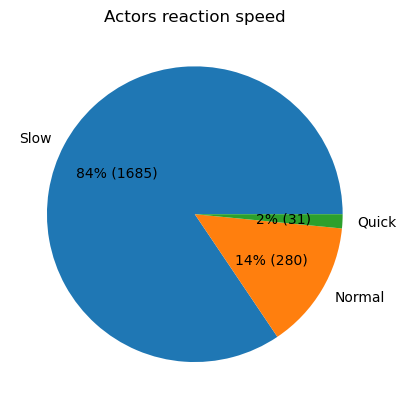

In [14]:
start_data_df_run["Attackers"] = (
    start_data_df_run["SingleAttacker"] + start_data_df_run["CoordinatedAttacker"] + start_data_df_run["Hacker"]
)

cols = ["Slow", "Normal", "Quick", "Attackers"]
values = np.array(start_data_df_run[cols])[0]
values[2] = values[2] - values[3]

if values[3] == 0:
    cols.pop()
    values = values[:-1]

n_actors = start_data_df_run["n_actors"]

fmt = lambda x: f"{int(x.round())}% ({int((x * n_actors / 100).round())})"
plt.pie(values, labels=cols, autopct=fmt)
plt.title("Actors reaction speed")

In [15]:
timestep_data_df_run_start = timestep_data_df_run[timestep_data_df_run["timestep"] == 1]

Text(0.5, 1.0, 'Tokens by reaction speed')

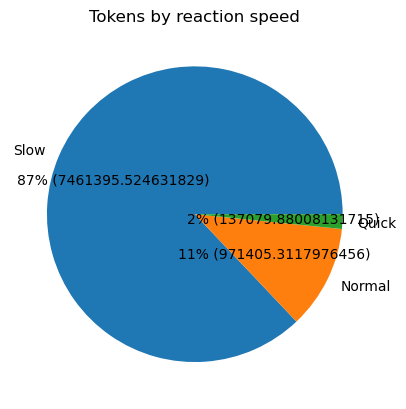

In [16]:
timestep_data_df_run_start = timestep_data_df_run[timestep_data_df_run["timestep"] == 1].copy()

attacker_labels = ["SingleAttacker", "CoordinatedAttacker", "Hacker"]
timestep_data_df_run_start["balance_Attackers"] = sum(
    timestep_data_df_run_start[attacker_label] for attacker_label in attacker_labels
)

cols = ["Slow", "Normal", "Quick", "Attackers"]
values = np.array(timestep_data_df_run_start[[f"balance_{col}" for col in cols]])[0]

if values[3] == 0:
    cols.pop()
    values = values[:-1]

initial_tokens = timestep_data_df_run_start["actors_total_balance"].sum()

fmt = lambda x: f"{int(x.round())}% ({x * initial_tokens / 100})"
plt.pie(values, labels=cols, autopct=fmt)
plt.title("Tokens by reaction speed")

In [17]:
initial_tokens = timestep_data_df_run.loc[timestep_data_df_run["timestep"] == 1, "actors_total_balance"].sum()
initial_hp = timestep_data_df_run.loc[timestep_data_df_run["timestep"] == 1, "actors_total_health"].sum()

timestep_data_df_run["actors_total_balance_relative"] = (
    timestep_data_df_run["actors_total_balance"] / initial_tokens * 100
)
timestep_data_df_run["actors_total_locked_relative"] = (
    timestep_data_df_run["actors_total_locked"] / initial_tokens * 100
)
timestep_data_df_run["actors_total_health_relative"] = timestep_data_df_run["actors_total_health"] / initial_hp * 100

veto_threshold = start_data_df_run["first_seal_rage_quit_support"]
ragequit_threshold = start_data_df_run["second_seal_rage_quit_support"]

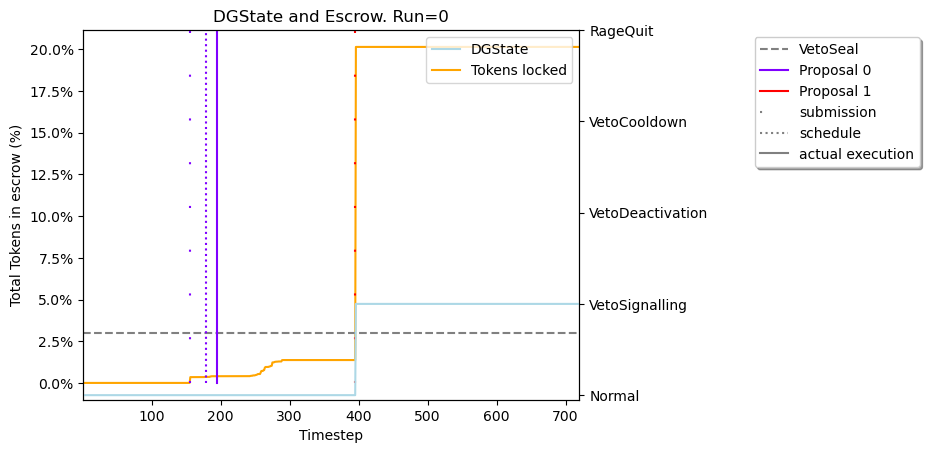

In [18]:
fig, ax = plt.subplots()

sns.lineplot(
    timestep_data_df_run, x="timestep", y="actors_total_locked_relative", color="orange", ax=ax, label="Tokens locked"
)
xlim = timestep_data_df_run["timestep"].min(), timestep_data_df_run["timestep"].max()
ax.plot(xlim, np.repeat(veto_threshold, 2), linestyle="--", color="gray", label="VetoSeal")
ax.set_xlim(xlim)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

ax2 = ax.twinx()
sns.lineplot(data=timestep_data_df_run, x="timestep", y="dg_state_value", color="lightblue", ax=ax2, label="DGState")
ax2.set_yticks([1, 2, 3, 4, 5], ["Normal", "VetoSignalling", "VetoDeactivation", "VetoCooldown", "RageQuit"])

add_proposal_data_to_timeplot(ax, proposal_df_run, [1, 0, 1, 0, 1])
handles, labels = ax.get_legend_handles_labels()
by_label_ax = dict(zip(labels, handles))
handles2, labels2 = ax2.get_legend_handles_labels()
by_label_ax2 = dict(zip(labels2, handles2))
by_label_ax2["Tokens locked"] = by_label_ax["Tokens locked"]
del by_label_ax["Tokens locked"]
ax.legend(by_label_ax.values(), by_label_ax.keys(), bbox_to_anchor=(1.7, 1), fancybox=True, shadow=True)
ax2.legend(by_label_ax2.values(), by_label_ax2.keys())

ax.set_xlabel("Timestep")
ax2.set_ylabel("")
ax.set_ylabel("Total Tokens in escrow (%)")
ax.set_title(f"DGState and Escrow. Run={run_id}");

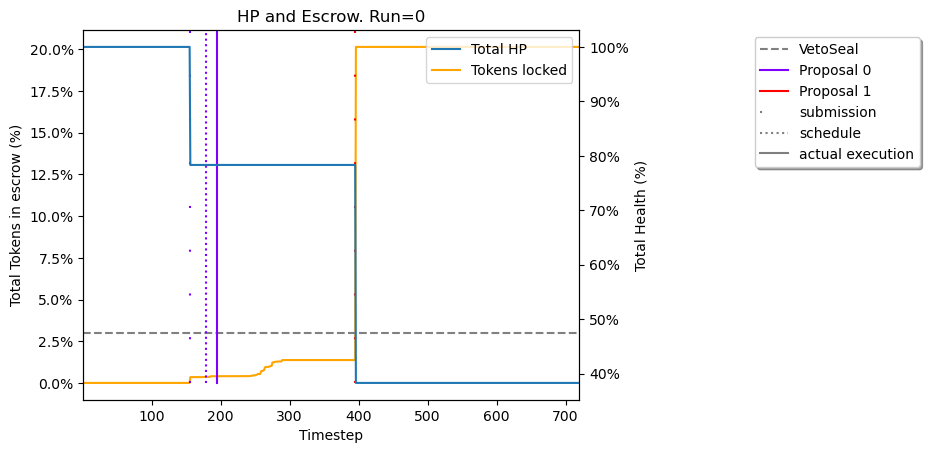

In [19]:
fig, ax = plt.subplots()

sns.lineplot(
    timestep_data_df_run, x="timestep", y="actors_total_locked_relative", color="orange", ax=ax, label="Tokens locked"
)
xlim = timestep_data_df_run["timestep"].min(), timestep_data_df_run["timestep"].max()
ax.plot(xlim, np.repeat(veto_threshold, 2), linestyle="--", color="gray", label="VetoSeal")
ax.set_xlim(xlim)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

ax2 = ax.twinx()
sns.lineplot(data=timestep_data_df_run, x="timestep", y="actors_total_health_relative", ax=ax2, label="Total HP")
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

add_proposal_data_to_timeplot(ax, proposal_df_run, [1, 0, 1, 0, 1])

handles, labels = ax.get_legend_handles_labels()
by_label_ax = dict(zip(labels, handles))
handles2, labels2 = ax2.get_legend_handles_labels()
by_label_ax2 = dict(zip(labels2, handles2))
by_label_ax2["Tokens locked"] = by_label_ax["Tokens locked"]
del by_label_ax["Tokens locked"]
ax.legend(by_label_ax.values(), by_label_ax.keys(), bbox_to_anchor=(1.7, 1), fancybox=True, shadow=True)
ax2.legend(by_label_ax2.values(), by_label_ax2.keys())

ax.set_xlabel("Timestep")
ax2.set_ylabel("Total Health (%)")
ax.set_ylabel("Total Tokens in escrow (%)")
ax.set_title(f"HP and Escrow. Run={run_id}");

In [20]:
timestep_data_df_run.columns

Index(['timestep', 'simulation_hash', 'dg_state_value', 'dg_state_name',
       'dg_rage_quit_support', 'dg_dynamic_timelock_seconds',
       'actors_total_balance', 'actors_total_locked', 'actors_total_number',
       'actors_total_health', 'balance_Normal', 'locked_Normal',
       'health_Normal', 'balance_Quick', 'locked_Quick', 'health_Quick',
       'balance_Slow', 'locked_Slow', 'health_Slow', 'balance_NoReaction',
       'locked_NoReaction', 'health_NoReaction', 'balance_BaseActor',
       'locked_BaseActor', 'health_BaseActor', 'balance_HonestActor',
       'locked_HonestActor', 'health_HonestActor', 'balance_SingleAttacker',
       'locked_SingleAttacker', 'health_SingleAttacker',
       'balance_CoordinatedAttacker', 'locked_CoordinatedAttacker',
       'health_CoordinatedAttacker', 'balance_Hacker', 'locked_Hacker',
       'health_Hacker', 'balance_SingleDefender', 'locked_SingleDefender',
       'health_SingleDefender', 'balance_CoordinatedDefender',
       'locked_Coordina

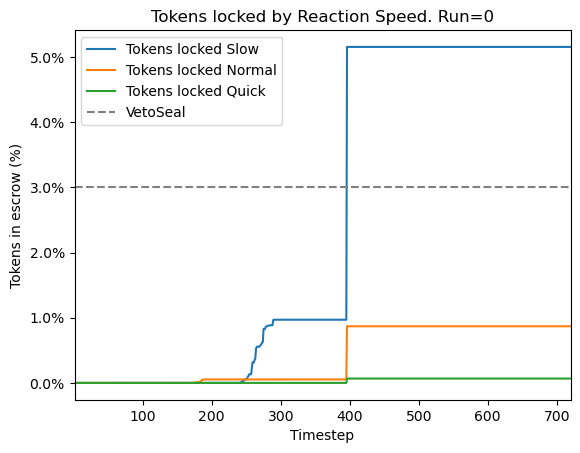

In [21]:
fig, ax = plt.subplots()
speed_labels = ["Slow", "Normal", "Quick"]
for speed_label in speed_labels:
    col_name = f"locked_{speed_label}_relative"
    timestep_data_df_run[col_name] = timestep_data_df_run[f"locked_{speed_label}"] / initial_tokens * 100
    sns.lineplot(timestep_data_df_run, x="timestep", y=col_name, ax=ax, label=f"Tokens locked {speed_label}")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

xlim = timestep_data_df_run["timestep"].min(), timestep_data_df_run["timestep"].max()
ax.plot(xlim, np.repeat(veto_threshold, 2), linestyle="--", color="gray", label="VetoSeal")
ax.set_xlim(xlim)

ax.legend()

ax.set_xlabel("Timestep")
ax2.set_ylabel("")
ax.set_ylabel("Tokens in escrow (%)")

ax.set_title(f"Tokens locked by Reaction Speed. Run={run_id}");

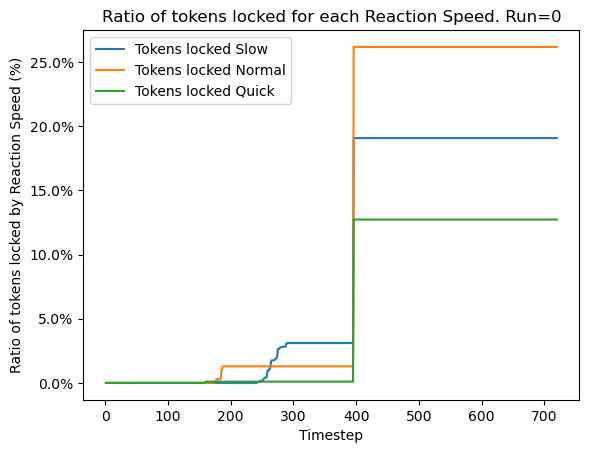

In [22]:
fig, ax = plt.subplots()
speed_labels = ["Slow", "Normal", "Quick"]
for speed_label in speed_labels:
    initial_tokens_speed = timestep_data_df_run[f"balance_{speed_label}"]

    col_name = f"locked_{speed_label}_relative"
    timestep_data_df_run[col_name] = timestep_data_df_run[f"locked_{speed_label}"] / initial_tokens_speed * 100
    sns.lineplot(timestep_data_df_run, x="timestep", y=col_name, ax=ax, label=f"Tokens locked {speed_label}")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

ax.legend()

ax.set_xlabel("Timestep")
ax2.set_ylabel("")
ax.set_ylabel("Ratio of tokens locked by Reaction Speed (%)")

ax.set_title(f"Ratio of tokens locked for each Reaction Speed. Run={run_id}");

In [23]:
vetoseal = timestep_data_df_full["first_seal_rage_quit_support"].unique()[0]
rageseal = timestep_data_df_full["second_seal_rage_quit_support"].unique()[0]
timestep_data_df_params = timestep_data_df_full[
    (timestep_data_df_full["first_seal_rage_quit_support"] == vetoseal)
    & (timestep_data_df_full["second_seal_rage_quit_support"] == rageseal)
].copy()

initial_tokens = timestep_data_df_params.loc[timestep_data_df_params["timestep"] == 1, "actors_total_balance"].iloc[0]
timestep_data_df_params["actors_total_locked_relative"] = (
    timestep_data_df_params["actors_total_locked"] / initial_tokens * 100
)

Text(0.5, 1.0, 'Escrow and DGState dynamics in different runs. VetoSeal=3.0, RageSeal=15.0')

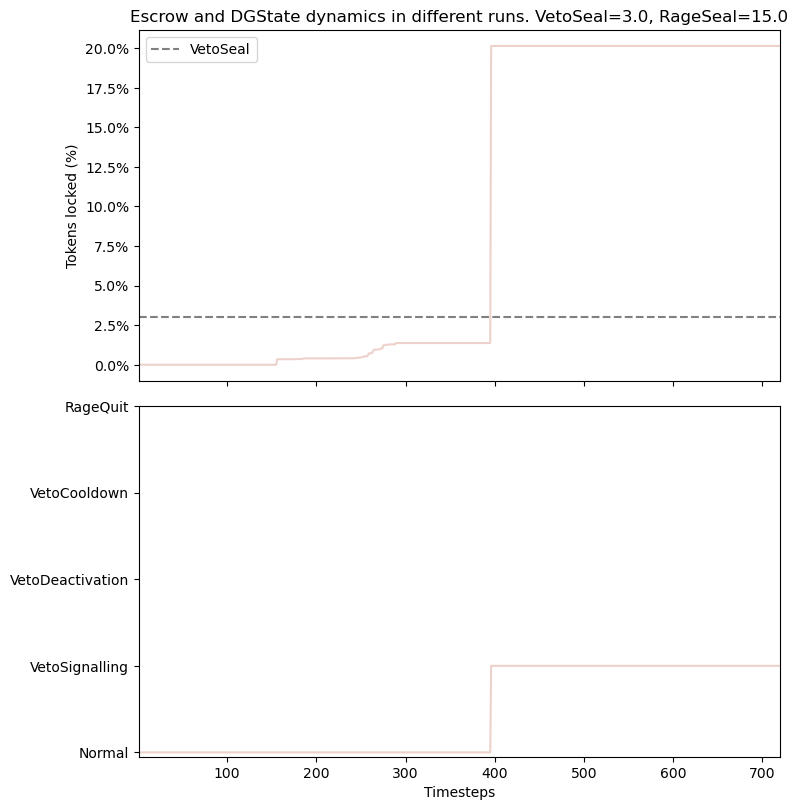

In [24]:
nrows = 2
ncols = 1
basesize = 4
figsize = (basesize * ncols * 2, basesize * nrows)
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=figsize)

ax = axes[0]
g = sns.lineplot(timestep_data_df_params, x="timestep", y="actors_total_locked_relative", ax=ax, hue="seed")
ax.legend().remove()
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

xlim = timestep_data_df_params["timestep"].min(), timestep_data_df_params["timestep"].max()
(line,) = ax.plot(xlim, np.repeat(vetoseal, 2), linestyle="--", color="gray", label="VetoSeal")
ax.set_xlim(xlim)

ax.legend([line], [line.get_label()])

ax.set_xlabel("")
ax.set_ylabel("Tokens locked (%)")

ax2 = axes[1]
g = sns.lineplot(timestep_data_df_params, x="timestep", y="dg_state_value", ax=ax2, hue="seed")
ax2.legend().remove()
ax2.set_yticks([1, 2, 3, 4, 5], ["Normal", "VetoSignalling", "VetoDeactivation", "VetoCooldown", "RageQuit"])
ax2.set_xlabel("Timesteps")
ax2.set_ylabel("")
fig.tight_layout()

ax.set_title(f"Escrow and DGState dynamics in different runs. VetoSeal={vetoseal}, RageSeal={rageseal}")